# k-NN Classifier

## Imports and custom functions

First, we import libraries, arrays and list we are going to use for this section.

We also redefine a custom function `display_classification_reports_confusion_matrices()` used after GridSearch to display classification report and confusion matrix overall, but also by customer class to assess predictive power for each customer class. `custom_format()` is used to reformat gridsearch results and improve readability.

In [1]:
import os
import time
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import cycle
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, make_scorer, f1_score, 
                             precision_score, recall_score, 
                             classification_report, ConfusionMatrixDisplay,
                             average_precision_score)
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler                    

In [2]:
def display_classification_reports_confusion_matrices(y_pred):
    """
    Takes predictions array as input and display classificaiton report overall and then
    Confusion matrices by customer class (rfm_label) that has been previously one hot encoded
    """
    # Create two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
    fig.subplots_adjust(wspace=0.8)

    # Plots standard confusion matrix
    ax1.set_title("Confusion Matrix (counts)")
    disp1 = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, display_labels=class_names, ax=ax1)
    disp1.ax_.set_xticklabels(class_names, rotation=90)
    disp1.im_.colorbar.remove()

    # Plots normalized confusion matrix
    ax2.set_title("Confusion Matrix (ratios)")
    disp2 = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, normalize="true", display_labels=class_names, ax=ax2)
    disp2.ax_.set_xticklabels(class_names, rotation=90)
    disp2.im_.colorbar.remove()

    # Get classification report
    print(classification_report(y_test, y_pred, output_dict=False, zero_division=1))
    
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)
    # Get precision, recall, f1 from report dict
    precision = round(report['weighted avg']['precision'], 2)
    recall = round(report['weighted avg']['recall'], 2)
    f1 = round(report['weighted avg']['f1-score'], 2)
    
    # Format title
    title_formatted = f"Overall Confusion Matrices\nprecision={precision} recall={recall} f1={f1}"
    
    fig.suptitle(title_formatted, y=1.005)
    plt.show()
    
    # OHE columns matching our rfm_labels
    labels_of_interest = ['rfm_label_Good Customers', 'rfm_label_Low Value Customers', 'rfm_label_VIP']

    # Find column indices corresponding to OHE rfm_label columns
    label_indices = [np.where(columns == label)[0][0] for label in labels_of_interest]

    # Iterate over each OHE rfm_label
    for i, label in enumerate(labels_of_interest):    
        # Find column position of OHE rfm_label
        label_index = label_indices[i]

        # Find unique values in the column of interest and their maximum
        unique_values = np.unique(X_test[:, label_index])
        max_value = np.max(unique_values)

        # Find rows of X_test where OHE rfm_label is true
        rows_of_interest = np.where(X_test[:, label_index] == max_value)
        
        # Select corresponding rows of y_test and y_pred
        y_test_subset = y_test[rows_of_interest]
        y_pred_subset = y_pred[rows_of_interest]

        # Restrict our class_names to only classes in subset
        # VIP can only become 5 values, other 6.
        classes = np.unique(y_test_subset)
        class_names_subset = [class_names[label] for label in classes if label in class_labels]

        fig, axs = plt.subplots(1, 2, figsize=(9, 4))

        # Plots standard confusion matrix
        axs[0].set_title("Confusion Matrix (counts)")
        disp1 = ConfusionMatrixDisplay.from_predictions(
            y_test_subset, y_pred_subset, display_labels=class_names_subset, ax=axs[0])
        disp1.ax_.set_xticklabels(class_names_subset, rotation=90)
        disp1.im_.colorbar.remove()

        # Plots normalized confusion matrix
        axs[1].set_title("Confusion Matrix (ratios)")
        disp2 = ConfusionMatrixDisplay.from_predictions(
            y_test_subset, y_pred_subset, normalize="true", display_labels=class_names_subset, ax=axs[1])
        disp2.ax_.set_xticklabels(class_names_subset, rotation=90)
        disp2.im_.colorbar.remove()

        # Get classification report
        report = classification_report(y_test_subset, y_pred_subset, output_dict=True, zero_division=1)
        # Get precision, recall, f1 from report dict
        precision = round(report['weighted avg']['precision'], 2)
        recall = round(report['weighted avg']['recall'], 2)
        f1 = round(report['weighted avg']['f1-score'], 2)
        # Format title
        title_formatted = f"{label}\nprecision={precision} recall={recall} f1={f1}"
        
        # Set figure title to label of interest
        fig.subplots_adjust(wspace=0.8)
        fig.suptitle(title_formatted, y=1.005)
        plt.show()

In [3]:
# Custom formatting for cv_results
pd.options.display.max_columns = None

def custom_format(value, col_name):
    if col_name.startswith('param_'):
        return value
    elif 'time' in col_name:
        return round(value, 0)
    elif 'mean' in col_name:
        return round(value, 3)
    elif 'std' in col_name:
        return round(value, 4)
    else:
        return value

Now, we load train and test set and also outliers arrays that can be used in outlier removal.

In [4]:
class_labels = [0, 1, 2, 3, 4]
class_names = ['Sleeping Dog', 'Low Value Customers', 'Sleeping Beauty', 'Good Customers', 'VIP']
colors = ['red', 'orange', 'purple', 'blue', 'green']

# Load test set from pickle file
with open('testset.pkl', 'rb') as f:
    testset = pickle.load(f)
X_test, y_test = testset['X_test'], testset['y_test']

# Load train set from pickle file
with open('trainset_base.pkl', 'rb') as f:
    trainset = pickle.load(f)
X_train, y_train = trainset['X_train'], trainset['y_train']

with open('columns.pkl', 'rb') as f:
    columns = pickle.load(f)
    
# Load dictionary containing all outliers array
with open("outliers.pkl", "rb") as f:
    loaded_outliers_dict = pickle.load(f)

In [5]:
X_train_outliers_conservative = loaded_outliers_dict["conservative"]
X_train_outliers_aggressive = loaded_outliers_dict["aggressive"]
X_train_outliers_lof = loaded_outliers_dict["lof"]
X_train_outliers_iforest = loaded_outliers_dict["iforest"]

outlier_dict = {
    "conservative": X_train_outliers_conservative,
    "aggressive": X_train_outliers_aggressive,
}

In [6]:
model_file_name = 'kNN.csv'

In [7]:
X_train.shape

(63700, 83)

Here is our machine learning plan from proposal

## Plan

Model interpretability, suitability, scalability, diversity, …?
- __Interpretability__ : KNN is a simple and intuitive model that is easy to understand. It predicts the class of a new data point based on the majority class among its K nearest neighbors in the training data. 
- __Suitability/Scalability__: The problem in our case is that our dataset has a relatively high number of features and KNN suffers from the curse of dimensionality, meaning in higher dimensions, all points tend to be equidistants. KNN should perform better computation wise than SVM, but we will try different algorithms to increase computation.
- __Diversity/Robustness__: KNN can be prone to overfitting depending on number of neighbors. The optimization of our KNN classifier has to be mindful of overfitting as outliers or noise can be reduced in influence by increase number of neighbors.

Methodologies to be used to train and finetune my models?

- We will use scikit-learn's GridSearchCV to find the best hyperparameters. The grid search involves an exhaustive search through a specified parameter grid and evaluates the model with cross-validation to find the best combination of hyperparameters. It will return both validation score and train score with return_train_score=True and this can be use to assess overfitting, as well as score on unseen test data. 

Model Parameters
- __n_neighbors__: This is the number of neighbors (K) that KNN will consider when making a prediction. We will experiment with a range of odd values to avoid ties. A small value of K will make the model sensitive to noise and more flexible, while a larger value will make it more stable and robust to noise but less flexible. Intuitively, we would want to avoid n-neighbors = 1 as this would imply high overfitting.
- __algorithm__: We will use the default 'auto' setting, which selects the most appropriate algorithm based on the dataset ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)). And we will also try out 'brute', and keep we 'brute' if the results are similar as computation speed should be better with 'brute'.
- __distance__ : We will try different weights, distance and uniform. By setting weight='distance' the model weights the target values of the nearest neighbors by their inverse distance. This creates a continuous spectrum of predictions, unlike weight='uniform' which creates regions of constant predictions (from [course](https://learn.extensionschool.ch/learn/programs/applied-data-science-machine-learning-v3/subjects/decision-trees-and-svms-v4/units/different-model-families-v2)).
- __Scaler__: We may also integrate different scalers into our pipeline, such as StandardScaler, and RobustScaler. Scaling the features is important because KNN is a distance-based algorithm, and features on different scales can negatively impact the model's performance. We try
    - 'passthrough': No scaling is applied to the data. We have seen that sometimes no scaler performs simply better than scaling.
    - StandardScaler(): Assumes that the data is normally distributed and scales the features to have a mean of 0 and a standard deviation of 1. 
    - RobustScaler(): Scales the features using interquartile range. It is good when data is not normally distributed.
- __PCA__: We will try out PCA to reduce dimensionality of our dataset, as it helps for dimensionality reduction by reducing the number of features by transforming the original features into a new set of components. Maybe this could help with KNN as it would lessen curse of dimensionality.

## Adaptations based on observations after running model

We simplify the following as we have seen better perfomance
- __Scalers__ : we have seen better performance using scaling than no scaling. We use RobustScaler as all our features are not all normally distributed.
- __PCA__ : we have seen better perfomance without using PCA in pipeline.
- **n_neighbors**: We try a few values and will fine tune our choice in last section
- We stop using parameter __leaf_size__ as it does not really help in reducing overfitting.

In [8]:
# Define the parameter grid
param_grid = {
    'preprocessor__scaler': [RobustScaler()],
    'dim_reduction': ['passthrough'],
    'classifier__n_neighbors': list(range(1, 10, 3)), 
}

# Create pipeline
pipe = Pipeline([
    ('preprocessor', ColumnTransformer(transformers=[
        ('scaler', 'passthrough', list(range(X_train.shape[1]))),
    ])),
    ('dim_reduction', 'passthrough'),
    ('classifier', KNeighborsClassifier())
])

# Initialize cv_results
cv_results = pd.DataFrame()
best_score = 0
best_params = None
best_outlier_name = None

for outlier_name, outlier_mask in outlier_dict.items():
    print("Removing outliers based on", outlier_name)

    # Remove rows with outliers from X_train and y_train
    X_train_filtered = X_train[outlier_mask != 1]
    y_train_filtered = y_train[outlier_mask != 1]

    # Use GridSearch to find the best parameter
    grid_search = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        cv=3,
        n_jobs=6,
        verbose=1,
        return_train_score=True,
        scoring={
            'f1': make_scorer(f1_score, average='weighted'),
            'precision': make_scorer(precision_score, average='weighted'),
            'recall': make_scorer(recall_score, average='weighted')
        },
        refit='f1'  
    )

    # Start timer
    start_time = time.time()

    # Fit grid search on training data
    grid_search.fit(X_train_filtered, y_train_filtered)

    # End timer
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Print time taken to fit the model
    print("Time taken to fit the model: {:.0f} seconds".format(elapsed_time))

    # Print best parameters found by GridSearchCV
    print("Best parameters found by GridSearchCV:", grid_search.best_params_)

    # Store the best parameters if the score is better than previous best
    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_params = grid_search.best_params_
        best_outlier_name = outlier_name
   
    # Evaluation on test data
    best_model = grid_search.best_estimator_
    test_score = best_model.score(X_test, y_test)
    print("Accuracy on unseen test data: {:.2f}%".format(test_score * 100))
    
    # Append current cv_results to the overall cv_results dataframe
    current_cv_results = pd.DataFrame(grid_search.cv_results_)
    current_cv_results['param_outliers_removal'] = outlier_name
    cv_results = cv_results.append(current_cv_results, ignore_index=True)

# Reset index of the overall cv_results dataframe
cv_results.reset_index(drop=True, inplace=True)

# Filter X_train and y_train based on best outlier removal method found
best_outlier_mask = outlier_dict[best_outlier_name]
X_train_best = X_train[best_outlier_mask != 1]
y_train_best = y_train[best_outlier_mask != 1]

# Fit best model
pipe.set_params(**best_params)
pipe.fit(X_train_best, y_train_best)

# Evaluation on test data
test_score = pipe.score(X_test, y_test)
print("Accuracy on unseen test data: {:.2f}%".format(test_score * 100))

# Assign pipeline to best_model
best_model = pipe

Removing outliers based on conservative
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Time taken to fit the model: 181 seconds
Best parameters found by GridSearchCV: {'classifier__n_neighbors': 1, 'dim_reduction': 'passthrough', 'preprocessor__scaler': RobustScaler()}
Accuracy on unseen test data: 69.18%
Removing outliers based on aggressive
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Time taken to fit the model: 161 seconds
Best parameters found by GridSearchCV: {'classifier__n_neighbors': 1, 'dim_reduction': 'passthrough', 'preprocessor__scaler': RobustScaler()}
Accuracy on unseen test data: 67.80%
Accuracy on unseen test data: 69.18%


In [9]:
cv_results = cv_results.sort_values("mean_test_f1", ascending=False)

file_path = os.path.join('gs_results', model_file_name)
cv_results.to_csv(file_path, index=False)

# Get columns starting with 'param_'
param_columns = [col for col in cv_results.columns if col.startswith('param_')]

# Create a list of desired column names
desired_columns = [
    'mean_fit_time',
    'mean_test_f1', 'mean_train_f1',
    *param_columns, 
    'std_test_f1', 'std_train_f1',
    'mean_test_precision', 'mean_train_precision',
    'std_test_precision', 'std_train_precision',
    'mean_test_recall', 'mean_train_recall',
    'std_test_recall', 'std_train_recall',    
]

# Apply custom formatting function and select columns
cv_results = cv_results.apply(lambda col: col.apply(lambda value: custom_format(value, col.name)))
cv_results = cv_results[desired_columns]
cv_results.head(10)

,mean_fit_time,mean_test_f1,mean_train_f1,param_classifier__n_neighbors,param_dim_reduction,param_preprocessor__scaler,param_outliers_removal,std_test_f1,std_train_f1,mean_test_precision,mean_train_precision,std_test_precision,std_train_precision,mean_test_recall,mean_train_recall,std_test_recall,std_train_recall
0,0.0,0.636,1.000,1,passthrough,RobustScaler(),conservative,0.0020,0.0000,0.637,1.000,0.0017,0.0000,0.636,1.000,0.0020,0.0000
3,0.0,0.634,1.000,1,passthrough,RobustScaler(),aggressive,0.0028,0.0000,0.634,1.000,0.0025,0.0000,0.634,1.000,0.0029,0.0000
1,0.0,0.533,0.736,4,passthrough,RobustScaler(),conservative,0.0012,0.0009,0.538,0.741,0.0007,0.0007,0.535,0.736,0.0016,0.0009
4,0.0,0.531,0.733,4,passthrough,RobustScaler(),aggressive,0.0015,0.0001,0.537,0.739,0.0009,0.0002,0.534,0.734,0.0018,0.0001
2,0.0,0.516,0.659,7,passthrough,RobustScaler(),conservative,0.0029,0.0003,0.519,0.663,0.0031,0.0003,0.519,0.661,0.0032,0.0003
5,0.0,0.514,0.658,7,passthrough,RobustScaler(),aggressive,0.0028,0.0008,0.517,0.662,0.0031,0.0009,0.518,0.660,0.0031,0.0007


## Results

### Classification report and Confusion matrices

We use our custom function to display confusion matrix and classications reports. Note that we don't extensively comment results here as they are from best model on validation f1 weighted score and we might end up chosing a different model with a better trade off between validation f1 weighted score and overfitting. We will do this in our results notebook, where we compile results from all our model.

              precision    recall  f1-score   support

           0       0.74      0.74      0.74      7803
           1       0.64      0.60      0.62      7823
           2       0.67      0.69      0.68      7800
           3       0.63      0.67      0.65      7740
           4       0.79      0.75      0.77      7834

    accuracy                           0.69     39000
   macro avg       0.69      0.69      0.69     39000
weighted avg       0.69      0.69      0.69     39000



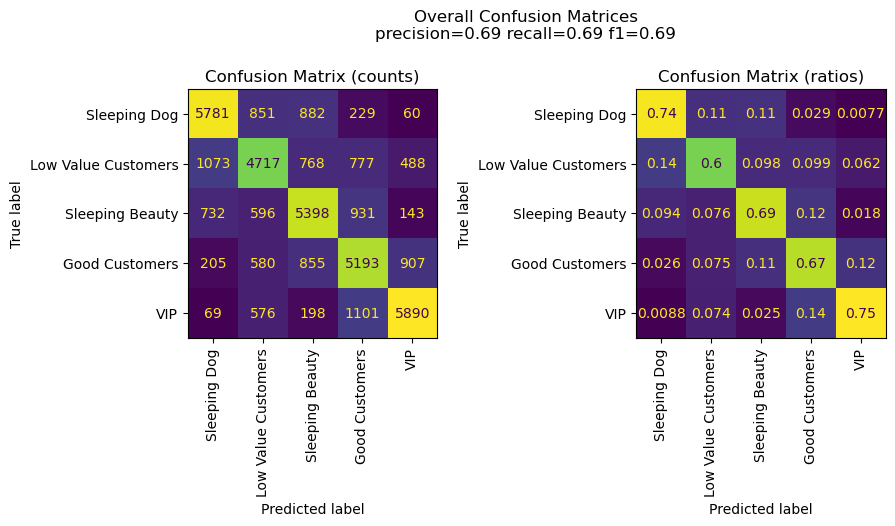

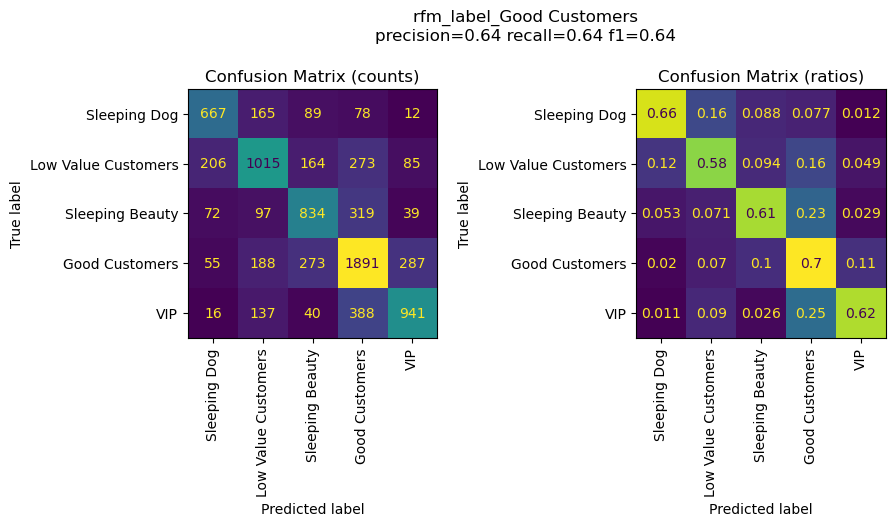

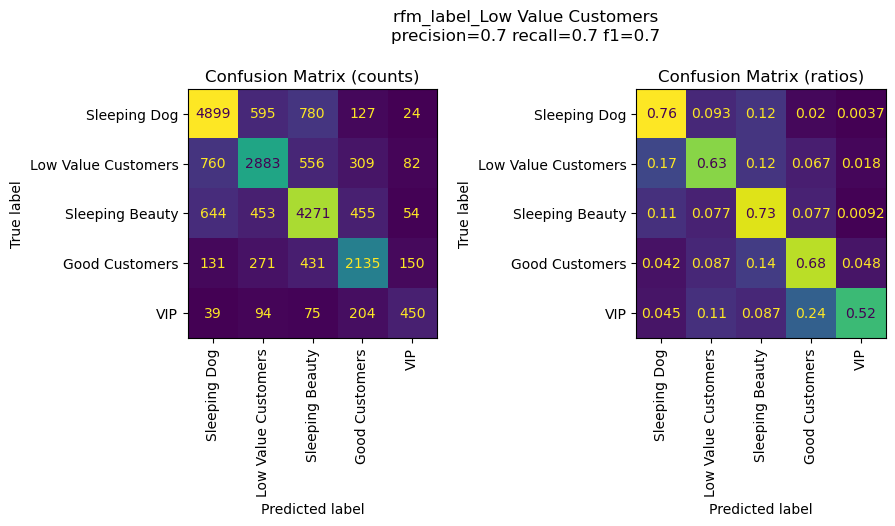

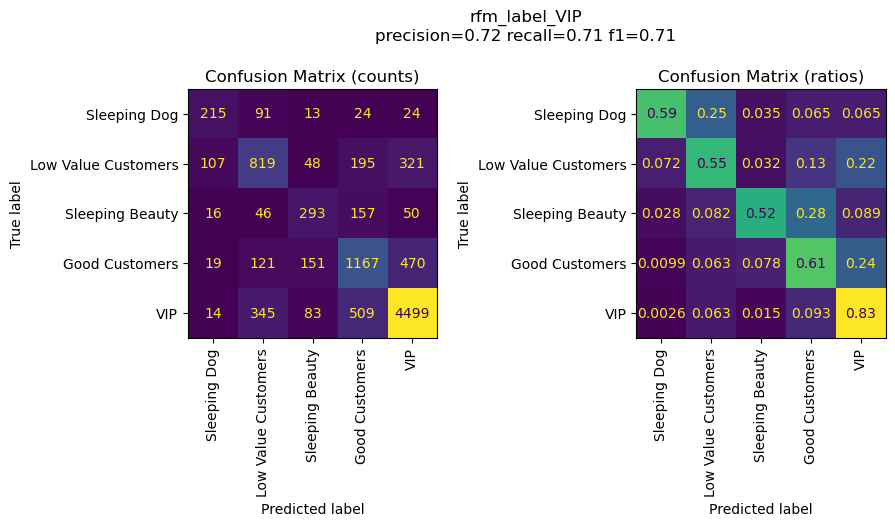

In [10]:
# Predict
y_pred = pipe.predict(X_test)
display_classification_reports_confusion_matrices(y_pred)

## Looking for optimal value of n_neighbors

Based on grid_search results we have seen that
- Classifier perfoms better with RobustScaler than without
- PCA is not useful
- Default metric (minkowsky) and weights (uniform) perform best
- Outliers exclusion that shows best performance is local outlier factor

We retrain using grid_search to search for optimal value of n_neighbors

In [11]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
# Remove rows with outliers from X_train and y_train
outlier_mask = X_train_outliers_aggressive
X_train_filtered = X_train[outlier_mask != 1]
y_train_filtered = y_train[outlier_mask != 1]

In [13]:
kNN = KNeighborsClassifier()

param_grid = {
    'n_neighbors': list(range(1, 50, 4))
}
                        

grid = GridSearchCV(
    kNN,
    param_grid=param_grid,
    n_jobs=6,
    cv=3,
    verbose=1,
    return_train_score=True,
    scoring={
        'f1': make_scorer(f1_score, average='weighted'),
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted')
    },
    refit='f1'  
)

# Fit to training
grid.fit(X_train, y_train)

# Print best parameters and corresponding score for training
print("Best parameters: {}".format(grid.best_params_))
print("Training score: {:.2f}".format(grid.best_score_))

Fitting 3 folds for each of 13 candidates, totalling 39 fits
Best parameters: {'n_neighbors': 1}
Training score: 0.64


In [14]:
cv_results = pd.DataFrame(grid.cv_results_)

columns = [
    "mean_test_f1",
    "std_test_f1",
    "mean_train_f1",
    "std_train_f1",
    "param_n_neighbors",
]

cv_results = cv_results[columns].sort_values("mean_test_f1", ascending=False)
cv_results.head(40)

,mean_test_f1,std_test_f1,mean_train_f1,std_train_f1,param_n_neighbors
0,0.638852,0.001808,1.000000,0.000000,1
1,0.532088,0.002694,0.708491,0.002045,5
2,0.508687,0.004403,0.632835,0.001372,9
3,0.500983,0.000919,0.596024,0.001913,13
4,0.492567,0.003534,0.569184,0.001123,17
5,0.488239,0.001220,0.553195,0.001452,21
6,0.484750,0.001921,0.539583,0.001862,25
7,0.481511,0.001886,0.529975,0.001645,29
8,0.477298,0.001443,0.522228,0.002450,33
9,0.472915,0.002058,0.515701,0.001851,37


## Plot the training and validation curves
We chose n_neighbors=10 as it is where overfitting starts to increase more importantly and to a difference of 10% of f1 weighted score between validation and train.

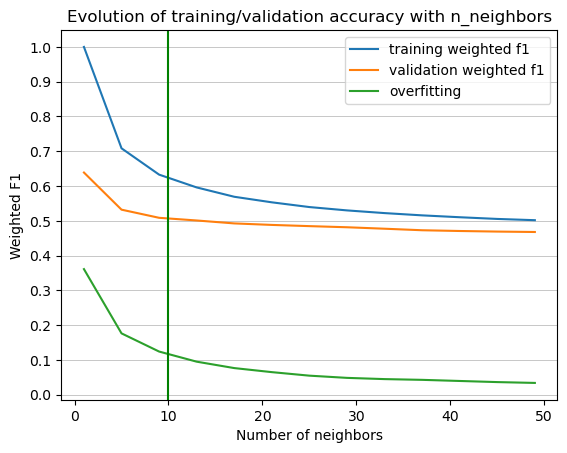

In [15]:
import matplotlib.ticker as ticker

# Calculate the overfitting
overfitting = cv_results["mean_train_f1"] - cv_results["mean_test_f1"]

# Plot training/validation/test accuracy curves
fig, ax = plt.subplots()
ax.plot(cv_results["param_n_neighbors"], cv_results["mean_train_f1"], label='training weighted f1')
ax.plot(cv_results["param_n_neighbors"], cv_results["mean_test_f1"],  label='validation weighted f1')

# Add the overfitting line
ax.plot(cv_results["param_n_neighbors"], overfitting, label='overfitting')

# Add horizontal gridlines with an increment of 0.1
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.grid(axis='y', linewidth=0.5)

ax.set_xlabel('Number of neighbors')
ax.set_ylabel('Weighted F1')
ax.axvline(10, c='g')

ax.set_title("Evolution of training/validation accuracy with n_neighbors")
ax.legend()
plt.show()